# Information

- Filename: `dissipation-theory--Study-46.ipynb`
- Continued from: `dissipation-theory--Study-45.ipynb`
- Continued to: `dissipation-theory--Study-47.ipynb`

# Preliminaries

In [1]:
import numpy as np
import matplotlib.pylab as plt
from dissipationtheory.constants import ureg, epsilon0, qe

In [2]:
THIS = 'dissipation-theory--Study-46--'
figs = {}

# Sphere capacitance computed by hand

## Image-charge and voltage-test points

Copy, and lightly edit, the code from `capacitancefinite.py` for generating the image-charge points and voltage-test points for a spherical tip.  The code editing it to bring the variable names into better alignment with my and Roger Loring's notes.

In [3]:
class twodimCobject():

    def addsphere(self, r, h, N, M):
        """Model a sphere of radius $r$ above a ground plane, with a tip-sample
        separation of $h$.  Create image-charge points $r_j$ and voltage-test 
        points $r_k$.  The $N$ image-charge points are placed along a vertical
        line extending from $h + 0.1 r$ to $h + 1.90 r$. The $M$ voltage-test 
        points are located uniformly around the sphere, starting at the south 
        pole, $\theta = -\pi/2$, and rotating counter clockwise. Initialize the
        values of the image charges at 1.0.  Creates two arrays: self.rk,
        the voltage-test points, and self.rj, the image-charge points.
        """

        # convert to nm and strip units
        h = h.to('nm').magnitude
        r = r.to('nm').magnitude

        # charge locations
        delta_array = np.linspace(start=-0.90, stop=0.90, endpoint=True, num=N)
        self.rj = np.array([[0, 0, h + r + r * delta] for delta in delta_array])

        # voltage-test locations
        theta_array = np.linspace(start=-np.pi/2, stop=3*np.pi/2, endpoint=False, num=M)
        self.rk = np.array([[r * np.cos(theta), 0, h + r + r * np.sin(theta)] for theta in theta_array])
        
        # save these
        self.info = {'type': 'sphere', 'r': r, 'h': h, 'N': N, 'M': M }
        self.title1 = f'sphere, $r$ = {r:0.1f} nm, $h$ = {h:0.1f} nm, $N$ = {N:d} image charges, $M$ = {M:d} test points'
        self.title2 = ''

        # initialize the results, useful for plotting
        self.results = {
            'alpha': 0, 
            'q': np.ones(N),
            'S': np.ones(N),
            'Sinv': np.ones(N),
            'cn': 0, 
            'V': np.zeros(M)}        

    def plot(self, N=0, M=0):
        """Plot, from left to right, (a) the voltage test points and the computed 
        image charges, (b) the relative voltage error around the object in parts per
        million, (c) image charge value versus position, and (d) singular values 
        for the response-function matrix."""

        if N == 0:
            N = self.info['N']

        if M == 0:
            M = self.info['M']
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8.00, 2.5))
        
        fig.suptitle(self.title1 + '\n' + self.title2, fontsize=10)
    
        cmap = plt.get_cmap('RdBu')
        ax1.scatter(self.rj[0:N,0], self.rj[0:N,2], 
            marker='.', c=self.results['q'][0:N], cmap=cmap, 
            alpha=0.5, edgecolors='face',
            vmin=-max(abs(self.results['q'][0:N])), 
            vmax=max(abs(self.results['q'][0:N])))
        ax1.scatter(self.rk[0:M,0], self.rk[0:M,2], marker='.')
        ax1.set_xlabel('$x$ [nm]')
        ax1.set_ylabel('$z$ [nm]')
        ax1.axis('equal')

        ax2.plot(self.rj[0:N,2], self.results['q'][0:N], '.-')
        ax2.set_xlabel('$(r_j)_{z}$ [nm]')
        ax2.set_ylabel('$q/q_{e}$')
        ax2.set_title(r''.format(), fontsize=10)

        V = self.results['V'][0:M]
        ax3.plot(1e6 * (V - np.ones_like(V)), '.-')
        ax3.set_xlabel('index')
        ax3.set_ylabel(r'$\delta V/V_0$ [ppm]')
        
        ax4.plot(self.results['S'][0:N], label='$\Lambda_k$')
        ax4.plot(self.results['Sinv'][0:N], label=r'${\mathrm{filt}}(\Lambda_k^{-1})$')
        ax4.set_xlabel('index $k$')
        ax4.set_ylabel('SVD')
        ax4.set_yscale('log')
        ax4.legend(fontsize=6, frameon=False)
        
        fig.tight_layout()
        
        return fig

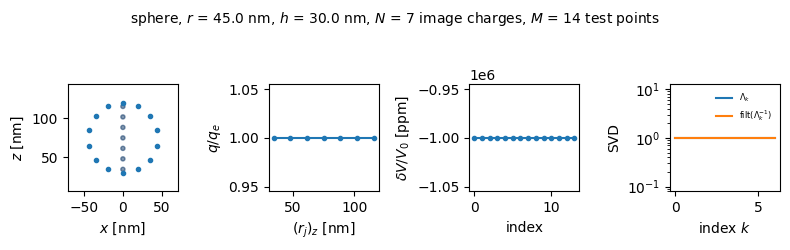

In [4]:
obj = twodimCobject()
params = {'r': ureg.Quantity(45.0, 'nm'),
          'h': ureg.Quantity(30.0, 'nm'),
          'N': 7, # image charges
          'M': 14} # test points

obj.addsphere(**params)
figs['01'] = obj.plot()

## Compute the capacitance for a free-standing sphere numerically

The image-charge locations are `obj.rj`.

In [5]:
obj.rj.shape

(7, 3)

The test-point locations are `obj.rk`.

In [6]:
obj.rk.shape

(14, 3)

Create a function that computes the Coulomb potential Green's function, the inverse distance between two points.

In [7]:
def Kcoulomb(location1, location2):
    return 1/np.linalg.norm(location1 - location2)

Compute the inverse distance between two selected vectors.

In [8]:
Kcoulomb(obj.rj[0], obj.rk[0])

0.2222222222222222

How to create a Green's function matrix?
Using a list comprehension is pretty fast!

In [9]:
%%timeit
np.array([[Kcoulomb(rj,rk) for rj in obj.rj] for rk in obj.rk])

592 μs ± 124 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Create the Green's function matrix. 

In [10]:
G0 = np.array([[Kcoulomb(rj,rk) for rj in obj.rj] for rk in obj.rk])
G0.shape

(14, 7)

We need this unitless constant.

In [11]:
Vr = ureg.Quantity(1, 'V')
zr = ureg.Quantity(1, 'nm')

cG = (qe / (4 * np.pi * epsilon0 * Vr * zr)).to('dimensionless').magnitude
cG

1.439964544247546

Use singular value decomposition to compute the array inverse.

In [12]:
U, S, VT = np.linalg.svd(G0, full_matrices=False)
Sinv = np.diag(np.power(S, -1)) # could add a filtering function here
G0inv = np.dot(np.dot(VT.T, Sinv), U.T)

Check that the inverse is good.  Compute $\hat{G}_0^{\dagger} \hat{G}_0$ and compare it to the $N \times N$ identity matrix $\text{I}_{N}$.  Here "compare" means print out the root mean square deviation of the matrix elements of $\hat{\epsilon} = \hat{G}_0^{\dagger} \hat{G}_0 - \text{I}_{N}$.

In [13]:
np.sqrt(np.mean(np.square(np.matmul(G0inv,G0) - np.diag(np.ones(obj.info['N'])))))

1.4934826200014336e-14

Compute the vector of charges.

In [14]:
IdM = np.ones(obj.info['M'])
q0 = np.power(cG,-1) * np.dot(G0inv, IdM)

Compute and print out the capacitance.

In [15]:
C0 = ((qe * q0.sum()) / Vr).to('aF')
C0

<Quantity(5.006925249515415, 'attofarad')>

The capacitance for sphere of radius $r$ is $C = 4 \pi \epsilon_0 r$.  Compute the capacitance for our $r = 45 \: \mathrm{nm}$ sphere.

In [16]:
C0calc = (4 * np.pi * epsilon0 * ureg.Quantity(45.0, 'nm')).to('aF')
C0calc

<Quantity(5.006925249515417, 'attofarad')>

A utility function to compare two numbers.

In [17]:
def compare(A,B):
    """Compute the relative difference between A to B, taking A as the ground truth."""
    print("relative error =", ((A - B)/A).to('dimensionless').magnitude)

Compare the numerically determined capacitance to the calculated capacitance.  They agree to within a few *parts per billion*.

In [18]:
compare(C0calc,C0)

relative error = 3.5477997990326916e-16


## Add a metallic substrate and recompute the capacitance

In [19]:
from dissipationtheory.dissipation8a import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation8b import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation8b import integrand1jit, integrand2jit, K_jit

In [20]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm'), 
    d = ureg.Quantity(38, 'nm')
)

sample1_metal = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(1e-6, 'nm'),  # not zero
    epsilon_s = ureg.Quantity(complex(1, 0), ''),
    sigma = ureg.Quantity(1e9, 'S/m'),
    rho = ureg.Quantity(1e26, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(1, 'nm') # important
)

sample1_jit_metal = SampleModel1Jit(**sample1_metal.args())

In [21]:
def Ksample(location1, location2): 

    K = K_jit(integrand=integrand1jit, 
            power=0,
            sample=sample1_jit_metal, 
            omega=0,
            location1=location1 * 1e-9,
            location2=location2 * 1e-9,
            isImag=False)

    return K.to('1/nm').magnitude

In [22]:
np.array([[Kcoulomb(rj,rk) for rj in obj.rj] for rk in obj.rk])

array([[0.22222222, 0.05555556, 0.03174603, 0.02222222, 0.01709402,
        0.01388889, 0.01169591],
       [0.05121687, 0.04208351, 0.02998029, 0.02222222, 0.01740268,
        0.01422293, 0.01199582],
       [0.02679675, 0.02841047, 0.02626391, 0.02222222, 0.01836551,
        0.01530498, 0.01297731],
       [0.01871806, 0.02125604, 0.02272207, 0.02222222, 0.02009015,
        0.01742169, 0.01494647],
       [0.01494647, 0.01742169, 0.02009015, 0.02222222, 0.02272207,
        0.02125604, 0.01871806],
       [0.01297731, 0.01530498, 0.01836551, 0.02222222, 0.02626391,
        0.02841047, 0.02679675],
       [0.01199582, 0.01422293, 0.01740268, 0.02222222, 0.02998029,
        0.04208351, 0.05121687],
       [0.01169591, 0.01388889, 0.01709402, 0.02222222, 0.03174603,
        0.05555556, 0.22222222],
       [0.01199582, 0.01422293, 0.01740268, 0.02222222, 0.02998029,
        0.04208351, 0.05121687],
       [0.01297731, 0.01530498, 0.01836551, 0.02222222, 0.02626391,
        0.02841047, 0.0

In [23]:
np.array([[- Ksample(rj,rk) for rj in obj.rj] for rk in obj.rk])

array([[-0.01550384, -0.01282049, -0.01092894, -0.00952379, -0.0084388 ,
        -0.00757574, -0.00687284],
       [-0.01395334, -0.01180127, -0.01021212, -0.00899407, -0.00803231,
        -0.00725445, -0.00661277],
       [-0.01127174, -0.00987633, -0.00877135, -0.00787916, -0.00714602,
        -0.00653415, -0.0060165 ],
       [-0.00919704, -0.00825046, -0.00746942, -0.00681661, -0.00626434,
        -0.00579193, -0.0053838 ],
       [-0.00785474, -0.00713969, -0.00653846, -0.00602703, -0.0055874 ,
        -0.00520587, -0.00487193],
       [-0.00704298, -0.00644744, -0.00594261, -0.00550964, -0.00513448,
        -0.00480645, -0.0045173 ],
       [-0.006609  , -0.00607145, -0.00561428, -0.00522079, -0.00487862,
        -0.00457837, -0.00431281],
       [-0.00647248, -0.00595237, -0.00550963, -0.00512819, -0.00479615,
        -0.0045045 , -0.00424628],
       [-0.006609  , -0.00607145, -0.00561428, -0.00522079, -0.00487862,
        -0.00457837, -0.00431281],
       [-0.00704298, -0.0064

In [24]:
G0 = np.array([[Kcoulomb(rj,rk) - Ksample(rj,rk)  for rj in obj.rj] for rk in obj.rk])
G0.shape

(14, 7)

Compute the capacitance again.

In [25]:
U, S, VT = np.linalg.svd(G0, full_matrices=False)
Sinv = np.diag(np.power(S, -1)) # could add a filtering function here
G0inv = np.dot(np.dot(VT.T, Sinv), U.T)

IdM = np.ones(obj.info['M'])
q0 = np.power(cG,-1) * np.dot(G0inv, IdM)
C0 = ((qe * q0.sum()) / Vr).to('aF')
C0

<Quantity(7.251521029897458, 'attofarad')>

It's larger, yea!  Compare it to the expected capacitance over a metal.

In [26]:
from dissipationtheory.capacitance import Csphere
import pint

In [27]:
h_array = pint.Quantity.from_list([params['h']]).to('nm')
Ccalc = Csphere(0, h_array, params['r']).to('aF')
Ccalc[0]

<Quantity(7.2514748935384254, 'attofarad')>

They agree to within a few parts per million.

In [28]:
compare(Ccalc[0],C0)

relative error = -6.3623414146869816e-06


How close the voltage is to the target 1.0V?
The standard deviation of the voltage about the target mean of 1.0 V is

In [29]:
np.std(cG * np.dot(G0, q0) - 1.0 * np.ones(obj.info['M']))

2.202965400326424e-05

which is just 22 parts per million.

# Sphere capacitance automated

In [30]:
from dissipationtheory.capacitance import Csphere

In [31]:
class twodimCobject2(twodimCobject):

    def __init__(self, sample, integrand):

        self.sample = sample
        self.integrand = integrand

        self.Vr = ureg.Quantity(1, 'V')
        self.zr = ureg.Quantity(1, 'nm')
        
        self.cG = (qe / (4 * np.pi * epsilon0 * self.Vr * self.zr)).to('dimensionless').magnitude
        self.cGinv = 1/self.cG
    
    def _compare(self, A, B):
        """Compute the relative difference between A to B, taking A as the ground truth."""
        return(1e6 * (A - B) / A)
    
    def _Kcoulomb(self, location1, location2):
        
        return complex(1,0) / np.linalg.norm(location1 - location2)
    
    def _Ksample(self, n, omega, location1, location2): 
        
        Kr = K_jit(integrand=self.integrand, 
                power=n,
                sample=self.sample, 
                omega=omega,
                location1=location1 * 1e-9,
                location2=location2 * 1e-9,
                isImag=False)

        Ki = K_jit(integrand=self.integrand, 
                power=n,
                sample=self.sample, 
                omega=omega,
                location1=location1 * 1e-9,
                location2=location2 * 1e-9,
                isImag=True)

        unit = '1/nm^{:d}'.format(n+1)
        
        return (complex(1,0) * Kr + complex(0,1) * Ki).to(unit).magnitude

    def solve(self, omega, alpha=0.):
        """Solve for the charges.  The parameter $\alpha$ is used to filter
        the singular values in the inverse.         
        """

        Kcoulomb = np.array([[self._Kcoulomb(rj,rk) for rj in self.rj] for rk in self.rk])
        K0 = np.array([[self._Ksample(0, omega, rj, rk) for rj in self.rj] for rk in self.rk])
        
        G0 = Kcoulomb - K0
        
        np.array([[self._Kcoulomb(rj,rk) - self._Ksample(0, omega, rj, rk)
                        for rj in self.rj] for rk in self.rk])
        
        U, S, VT = np.linalg.svd(G0, full_matrices=False)
        filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
        Sinv = filt * np.diag(np.power(S, -1))
        G0inv = VT.T @ Sinv @ U.T

        self.results['S'] = S                      # unitless
        self.results['Sinv'] = np.diagonal(Sinv)   # unitless
        self.results['cn'] = S.max()/S.min()       # unitless
        
        IdN = np.ones(self.info['N']).T
        IdM = np.ones(self.info['M'])

        Q = self.cGinv * complex(0,1) * G0inv @ IdM
        V = -1 * complex(0,1) * self.cG * G0 @ Q

        self.results['q'] = np.imag(Q) # units of qe 
        self.results['V'] = np.real(V) # units of Vr
        
        K1 = np.array([[self._Ksample(1, omega, rj, rk)  for rj in self.rj] for rk in self.rk]) 
        K2 = np.array([[self._Ksample(2, omega, rj, rk)  for rj in self.rj] for rk in self.rk]) 
        
        L0 = IdN @ G0inv @ IdM
        L1 = -2 * IdN @ G0inv @ K1 @ G0inv @ IdM
        L2 = 4 * IdN @ (G0inv @ K2 @ G0inv + 2 * G0inv @ K1 @ G0inv @ K1 @ G0inv) @ IdM

        self.results['L0'] = L0
        self.results['L1'] = L1
        self.results['L2'] = L2
        
        c = self.cGinv * (qe / self.Vr)
        C0 = (c / self.zr**0) * np.imag(complex(0,1) * L0) 
        C1 = (c / self.zr**1) * np.imag(complex(0,1) * L1) 
        C2 = (c / self.zr**2) * np.imag(complex(0,1) * L2)
        
        h_array = ureg.Quantity(np.array([self.info['h']]), 'nm')
        r = ureg.Quantity(self.info['r'], 'nm')
        
        for key, values, unit in zip(
            ['C0 [aF]', 'C1 [pF/m]', 'C2 [mF/m^2]'],
            [C0, C1, C2],
            ['aF', 'pF/m', 'mF/m^2']):

            self.results[key] = values.to(unit).magnitude

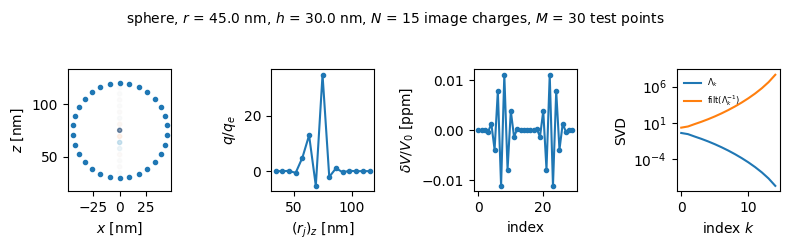

In [32]:
obj2 = twodimCobject2(sample1_jit_metal,integrand1jit)

params = {'r': ureg.Quantity(45.0, 'nm'),
          'h': ureg.Quantity(30.0, 'nm'),
          'N': 15, # image charges
          'M': 30} # test points

obj2.addsphere(**params)
obj2.solve(0.)
figs['02'] = obj2.plot()

In [33]:
obj2.results

{'alpha': 0,
 'q': array([ 3.86555221e-04, -9.84214922e-03,  9.51167312e-02, -6.25430660e-01,
         4.83627285e+00,  1.29131000e+01, -5.30390592e+00,  3.46999657e+01,
        -2.07034566e+00,  1.03262916e+00, -4.05294538e-01,  1.18673526e-01,
        -2.39236229e-02,  2.81839592e-03, -1.17323011e-04]),
 'S': array([4.30704312e-01, 2.99241608e-01, 1.39980912e-01, 6.74028370e-02,
        3.01382460e-02, 1.24747877e-02, 4.77217552e-03, 1.67491228e-03,
        5.36601554e-04, 1.55506111e-04, 4.01664475e-05, 9.03460694e-06,
        1.70339858e-06, 2.50834077e-07, 2.43250704e-08]),
 'Sinv': array([2.32177847e+00, 3.34178127e+00, 7.14383116e+00, 1.48361708e+01,
        3.31804313e+01, 8.01616848e+01, 2.09548035e+02, 5.97046192e+02,
        1.86358014e+03, 6.43061546e+03, 2.48964014e+04, 1.10685501e+05,
        5.87061660e+05, 3.98669915e+06, 4.11098502e+07]),
 'cn': 17706189.780987307,
 'V': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.00000001, 

# Simulate the capacitances and various heights

This calculation takes a minute.

In [34]:
comp = {}
calc = {}
obj = {}

r = ureg.Quantity(30., 'nm')
h_array = ureg.Quantity(
    np.logspace(
        start=np.log10(15e-9),
        stop=np.log10(1e-6),
        num=20,
        endpoint=True), 
    'm')

for key, unit in zip(['C0', 'C1', 'C2'], ['aF', 'pF/m', 'mF/m^2']):
    comp[key] = np.zeros_like(h_array)



for index, h in enumerate(h_array):

    params = {'r': r,
              'h': h,
              'N': 15, # image charges
              'M': 30} # test points

    obj[index] = twodimCobject2(sample1_jit_metal,integrand1jit)
    obj[index].addsphere(**params)
    obj[index].solve(0.)
    
    for key, keyobj in zip(['C0', 'C1', 'C2'], ['C0 [aF]', 'C1 [pF/m]', 'C2 [mF/m^2]']):
        comp[key][index] = obj[index].results[keyobj]
    
for key, index, unit in zip(['C0', 'C1', 'C2'], [0, 1, 2], ['aF', 'pF/m', 'mF/m^2']):
    calc[key] = Csphere(index, h_array, r).to(unit).magnitude

In [35]:
import pandas as pd

In [36]:
df = pd.DataFrame.from_dict(
    {'h [nm]': h_array.to('nm').magnitude, 
     '$C_0$ [aF] comp': comp['C0'],
     '$C_0$ [aF] calc': calc['C0'],
     '$\epsilon_{C_0}$ [ppm]': 1e6 * ((comp['C0'] - calc['C0'])/comp['C0']),
     '$C_1$ [pF/m] comp': comp['C1'],
     '$C_1$ [pF/m] calc': calc['C1'],
     '$\epsilon_{C_1}$ [ppm]': 1e6 * ((comp['C1'] - calc['C1'])/comp['C1']),
     '$C_2$ [mF/m$^2$] comp': comp['C2'],
     '$C_2$ [mF/m$^2$] calc': calc['C2'],
     '$\epsilon_{C_2}$ [ppm]': 1e6 * ((comp['C2'] - calc['C2'])/comp['C2'])
    }
)

In [37]:
df

,h [nm],$C_0$ [aF] comp,$C_0$ [aF] calc,$\epsilon_{C_0}$ [ppm],$C_1$ [pF/m] comp,$C_1$ [pF/m] calc,$\epsilon_{C_1}$ [ppm],$C_2$ [mF/m$^2$] comp,$C_2$ [mF/m$^2$] calc,$\epsilon_{C_2}$ [ppm]
0,15.000000,5.124984,5.124990,-1.165851,-70.723483,-70.723791,-4.354871,6.233566,6.233577,-1.703188
1,18.710546,4.899017,4.899022,-1.008773,-52.537824,-52.538068,-4.644599,3.841481,3.841500,-4.962344
2,23.338968,4.690706,4.690710,-0.852932,-38.618002,-38.618169,-4.329572,2.345715,2.345728,-5.801972
3,29.112322,4.500757,4.500760,-0.716397,-28.067791,-28.067899,-3.833174,1.417258,1.417266,-5.349313
4,36.313829,4.329539,4.329542,-0.602048,-20.160860,-20.160928,-3.390864,0.846133,0.846137,-4.523119
5,45.296771,4.177032,4.177035,-0.506307,-14.308437,-14.308481,-3.073475,0.498610,0.498612,-3.812936
6,56.501820,4.042811,4.042812,-0.424791,-10.034455,-10.034483,-2.861638,0.289795,0.289796,-3.691569
7,70.478660,3.926061,3.926062,-0.354582,-6.956457,-6.956476,-2.714375,0.166076,0.166076,1.751142
8,87.912946,3.825641,3.825642,-0.294112,-4.770601,-4.770613,-2.600129,0.093863,0.093864,-2.872018
9,109.659947,3.740161,3.740162,-0.242506,-3.239231,-3.239239,-2.503284,0.052355,0.052355,-2.734363


Why is the error in the numerically computed $C_2$ diverging at *large* tip-sample separations?

Examine some of the solutions.

Close up we see two images charges, as expected.

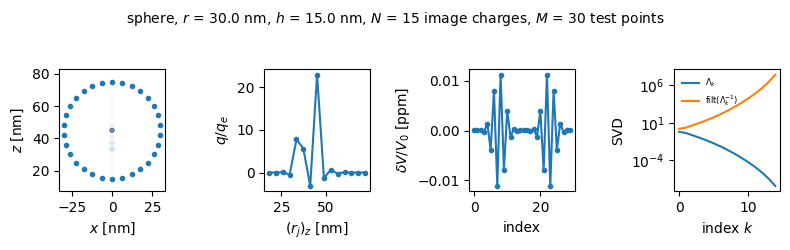

In [38]:
figs['03a'] = obj[0].plot()

Far away we see one image charge at the center of the sphere, again as expected.

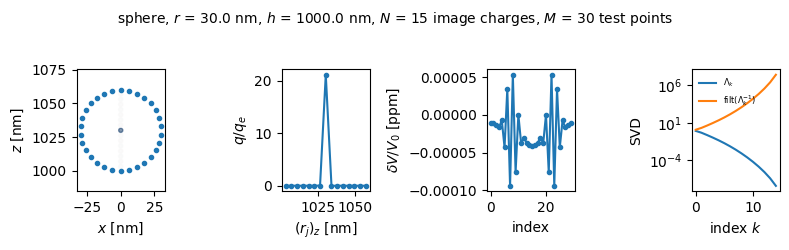

In [39]:
figs['03b'] = obj[19].plot()

# Save the figures

In [40]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-46.ipynb && open dissipation-theory--Study-46.html
    
:::